In [1]:
def iou_2d(box1, box2):
    box1 = box1.flatten()
    box2 = box2.flatten()
    area1 = (box1[2]-box1[0])*(box1[3]-box1[1])
    area2 = (box2[2]-box2[0])*(box2[3]-box2[1])
    area_sum = abs(area1) + abs(area2)
    
    #計算重疊方形座標
    x1 = max(box1[0], box2[0]) # left
    y1 = max(box1[1], box2[1]) # top
    x2 = min(box1[2], box2[2]) # right
    y2 = min(box1[3], box2[3]) # btm

    if x1 >= x2 or y1 >= y2:
        return 0
    else:
        inter_area = abs((x2-x1)*(y2-y1))
    return inter_area/(area_sum-inter_area)

In [2]:
class DetectedObject(object):
    def __init__(self, line):
        self.line = line
        self.class_ = None
        self.box2d = None
        self.dims = None
        self.locs = None
        self.rys = None
        self.id = None
        self.frames = list()
        self.crops = list()
        self.lines = list()
        self.set_info(line)
        
    def set_info(self, line):
        self.lines.append(line)
        elements = line.split()
        for j in range(1, len(elements)):
            elements[j] = float(elements[j])
        top_left = [int(round(elements[4])), int(round(elements[5]))]
        btm_right = [int(round(elements[6])), int(round(elements[7]))]
        self.box2d = np.array([top_left, btm_right])
        self.class_ = elements[0]
        self.alphas = [elements[3]]
        self.dims = [[elements[8], elements[9], elements[10]]]
        self.locs = [[elements[11], elements[12], elements[13]]]
        self.rys = [elements[14]]
        if len(elements) == 16:
            self.id = int(elements[15])
    
    def update_info(self, obj):
        self.box2d = obj.box2d
        self.alphas += obj.alphas
        self.dims += obj.dims
        self.locs += obj.locs
        self.rys += obj.rys
        self.lines.append(obj.line)
        
    def record_frames(self, frame_id):
        self.frames.append(frame_id)

In [ ]:
import glob
import numpy as np
import cv2
import os
cam_to_img = np.array([
        [ 1.418667e+03, 0.000000e+00, 6.4e+02,0],
        [ 0.000000e+00, 1.418667e+03, 3.6e+02,0],
        [ 0.000000e+00, 0.000000e+00, 1.000000e+00,0]])

#1532~1632 tracking
#40-60 tracking
images = glob.glob('Elan_3d_box/image_2/*.png')
renew_labels = glob.glob('Elan_3d_box/renew_label/*.txt')

trainset = [x.strip() for x in open('Elan_3d_box/ImageSets/train.txt').readlines()]
print(len(trainset))
print(trainset[-1])
# train 0-1605.txt
# val 1606-txt
os.makedirs('Elan_3d_box/renew_label_obj', exist_ok=True)
def tracking_obj_by_labels(label, start, end, WRITE_FILE=False, folder='renew_label', new_folder='renew_label_obj'):
    tracking_dict = dict()
    for idx in range(start, end):
        #print(f'======{idx}====={label[idx]}====')
        lines = [x.strip() for x in open(label[idx]).readlines()]
        new_lines = [line for line in lines]
        img = cv2.cvtColor(cv2.imread(images[idx]), cv2.COLOR_BGR2RGB)
        objects = [DetectedObject(line) for line in lines]
        if len(tracking_dict.keys()) == 0:
            for id_, obj in enumerate(objects):
                
                tracking_dict[id_] = obj
                tracking_dict[id_].record_frames(idx)
                new_lines[id_] += f' {id_}'
                #top_left, btm_right = obj.box2d
                #crop = img[top_left[1]:btm_right[1]+1, top_left[0]:btm_right[0]+1]
                #tracking_dict[id_].crops.append(crop)
        else:
            for obj_idx, obj in enumerate(objects):
                #print(obj.class_)
                now_box2d = obj.box2d
                match = False
                #top_left, btm_right = obj.box2d
                #crop = img[top_left[1]:btm_right[1]+1, top_left[0]:btm_right[0]+1]
                for key in tracking_dict.keys():
                    last_box2d = tracking_dict[key].box2d
                    iou_value = iou_2d(now_box2d, last_box2d)
                    last_frame = tracking_dict[key].frames[-1]
                    if iou_value > 0.6 and idx - last_frame < 5:
                        #print(f'MATCHED:{iou_value:.2f}')
                        match = True
                        tracking_dict[key].update_info(obj)
                        tracking_dict[key].record_frames(idx)
                        #tracking_dict[key].crops.append(crop)
                        new_lines[obj_idx] += f' {key}'
                        break
                if not match: #new obj
                    new_id = len(tracking_dict.keys())
                    tracking_dict[new_id] = obj
                    tracking_dict[new_id].record_frames(idx)
                    #tracking_dict[new_id].crops.append(crop)
                    new_lines[obj_idx] += f' {key}'
        if WRITE_FILE:
            with open(label[idx].replace('renew_label', 'renew_label_obj'), 'w') as f:
                for line in new_lines:
                    f.writelines(line + '\n')
    return tracking_dict

In [65]:
tracking_dict = tracking_obj_by_labels(renew_labels, 0, len(renew_labels), WRITE_FILE=True)

### 0719 DOING frame consistency

In [135]:
from library.ron_utils import *
from torch_lib.ClassAverages import *

def get_object_label(objects, bin_num=4):
    ELAN_averages = ClassAverages(average_file='renew_ELAN_class_averages.txt')
    label = dict()
    Heading_class = list()
    Residual = list()
    Dim_delta = list()
    TrackID = list()
    for obj in objects:
        heading_class, residual = angle2class(obj.alphas[0], bin_num)
        dim_delta = np.array(obj.dims[0]) - ELAN_averages.get_item(obj.class_)
        obj_id = obj.id
        Heading_class.append(heading_class)
        Residual.append(residual)
        Dim_delta.append(dim_delta)
        TrackID.append(obj_id)
    label['bin'] = torch.tensor(Heading_class)
    label['residual'] = torch.tensor(Residual)
    label['dim_delta'] = torch.tensor(np.array(Dim_delta))
    label['track_id'] = TrackID
    return label

In [134]:
from torchvision.models import vgg
from torch_lib.Model_heading_bin import *
from torchvision import transforms
import torch.nn.functional as F

device = 'cpu'
#device = 'cuda'
trainset = [x.strip() for x in open('Elan_3d_box/ImageSets/train.txt').readlines()]
bin_num = 4
angle_per_class = 2*np.pi/float(bin_num)
batch_size = 16

my_vgg = vgg.vgg19_bn(weights='DEFAULT')
model = Model(features=my_vgg.features, bins=bin_num).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
process = transforms.Compose([transforms.ToTensor(), 
                              transforms.Resize([224,224]),
                            #transforms.Normalize(mean=[0.596, 0.612, 0.587], std=[0.256, 0.254, 0.257])
                              transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                            ])

count = 0
batch_count = 0
start = 0
for epoch in range(50):
    for id_ in trainset:
        img = cv2.cvtColor(cv2.imread(f'Elan_3d_box/image_2/{id_}.png'), cv2.COLOR_BGR2RGB)
        label = f'Elan_3d_box/renew_label_obj/{id_}.txt'
        lines = [x.strip() for x in open(obj_label).readlines()]
        obj_count = len(lines)
        batch_count += len(lines)

        if obj_count == 0:
            continue
        objects = [DetectedObject(line) for line in lines]
        crops = [process(img[obj.box2d[0][1]:obj.box2d[1][1]+1 ,obj.box2d[0][0]:obj.box2d[1][0]+1]) for obj in objects]
        crops = torch.stack(crops).to(device)

        gt_labels = get_object_label(objects, bin_num)
        gt_bin = gt_labels['bin'].to(device)
        gt_residual = gt_labels['residual'].to(device)
        gt_dim_delta = gt_labels['dim_delta'].to(device)
        now_id = gt_labels['track_id']

        [reg_residual, reg_bin, reg_dim_delta] = model(crops)

        bin_loss = F.cross_entropy(reg_bin, gt_bin, reduction='mean')
        redisual_loss, _ = compute_residual_loss(reg_residual, gt_bin, gt_residual, device)
        dim_loss = F.l1_loss(reg_dim_delta, gt_dim_delta, reduction='mean')

        if count == 0:
            consist_loss = torch.tensor(0.0)
            count +=1
        else:
            now_id_list, last_id_list = id_compare(now_id, last_id)
            #print(now_id, last_id)
            if len(now_id_list) != 0:
                reg_dim_delta_id = reg_dim_delta[now_id_list]
                last_dim_delta_id = last_dim_delta[last_id_list]
                consist_loss = F.l1_loss(reg_dim_delta_id, last_dim_delta_id, reduction='mean') * len(now_id_list) / len(now_id)
            else:
                consist_loss = torch.tensor(0.0)
            #print(consist_loss)

        angle_loss = bin_loss + redisual_loss
        loss = 0.6 * dim_loss + angle_loss + consist_loss

        last_bin = torch.clone(reg_bin).detach()
        last_residual = torch.clone(reg_residual).detach()
        last_dim_delta = torch.clone(reg_dim_delta).detach()
        last_id = now_id
        #https://zhuanlan.zhihu.com/p/65002487
        loss = loss / obj_count
        loss.backward()  # 计算梯度
        if(batch_count//batch_size)== 1:
            #print(batch_count)
            batch_count = 0 
            optimizer.step()        
            optimizer.zero_grad()
    
# 68/1591 是沒有consist_loss的

In [123]:
4931 / 8

616.375

In [107]:
def id_compare(now_id, last_id):
    now_id_list = list()
    last_id_list = list()
    for idx, id_ in enumerate(now_id):
        try:
            find_idx = last_id.index(id_)
        except:
            find_idx = -1

        if find_idx != -1:
            now_id_list.append(idx)
            last_id_list.append(find_idx)
    return now_id_list, last_id_list

In [161]:
# GT
tracking_dict = tracking_obj_by_labels(renew_labels, 0, len(renew_labels))
def tracking_dimension_list(tracking_dict, frame_threshold=10):
    Hs = list()
    Ws = list()
    Ls = list()
    for key in tracking_dict.keys():
        obj = tracking_dict[key]
        H = list()
        W = list()
        L = list()
        if len(obj.frames) < frame_threshold:
            continue
        for i in range(len(obj.frames)):
            height, width, length = obj.dim[i]
            H.append(height)
            W.append(width)
            L.append(length)
        Hs.append(H)
        Ws.append(W)
        Ls.append(L)
    return np.array(Hs), np.array(Ws), np.array(Ls)

H, W, L = tracking_dimension_list(tracking_dict)

print(f'H mean {H.mean():.2f}, std {H.std():.2f}')
print(f'W mean {W.mean():.2f}, std {W.std():.2f}')
print(f'L mean {L.mean():.2f}, std {L.std():.2f}')
print('='*20)

H mean 1.77, std 0.04
W mean 1.85, std 0.09
L mean 3.67, std 0.07


In [159]:
tracking_dict

{0: <__main__.DetectedObject at 0x1798e321400>,
 1: <__main__.DetectedObject at 0x1798e321550>,
 2: <__main__.DetectedObject at 0x1799111bb80>,
 3: <__main__.DetectedObject at 0x1799111b9a0>,
 4: <__main__.DetectedObject at 0x1799111b880>,
 5: <__main__.DetectedObject at 0x1799111b2e0>,
 6: <__main__.DetectedObject at 0x1799111bf10>,
 7: <__main__.DetectedObject at 0x1799111b070>}

In [157]:
# KITTI
for key in tracking_dict.keys():
    obj = tracking_dict[key]
    H = list()
    W = list()
    L = list()
    if len(obj.frames) < 10:
        continue
    for i in range(len(obj.frames)):
        height, width, length = obj.dim[i]
        H.append(height)
        W.append(width)
        L.append(length)
    
    H = np.array(H)
    W = np.array(W)
    L = np.array(L)
    print(f'H mean {H.mean():.2f}, std {H.std():.2f}')
    print(f'W mean {W.mean():.2f}, std {W.std():.2f}')
    print(f'L mean {L.mean():.2f}, std {L.std():.2f}')
    print('='*20)

H mean 1.77, std 0.04
W mean 1.85, std 0.09
L mean 3.67, std 0.07


In [132]:
# ELAN
for key in tracking_dict.keys():
    obj = tracking_dict[key]
    H = list()
    W = list()
    L = list()
    if len(obj.frames) < 10:
        continue
    for i in range(len(obj.frames)):
        height, width, length = obj.dim[i]
        H.append(height)
        W.append(width)
        L.append(length)
    
    H = np.array(H)
    W = np.array(W)
    L = np.array(L)
    print(f'H mean {H.mean():.2f}, std {H.std():.2f}')
    print(f'W mean {W.mean():.2f}, std {W.std():.2f}')
    print(f'L mean {L.mean():.2f}, std {L.std():.2f}')
    print('='*20)

H mean 1.74, std 0.03
W mean 1.92, std 0.01
L mean 4.41, std 0.08
H mean 1.50, std 0.03
W mean 1.87, std 0.03
L mean 4.05, std 0.12


## Dimension ratio calculation

In [166]:
len(L_H)

7481

In [178]:
kitti_labels = glob.glob('Kitti/training/label_2/*.txt')

L_H = list()
L_W = list()

for i in range(len(kitti_labels)):
    lines = [x.strip() for x in open(kitti_labels[i]).readlines()]
    objects = [DetectedObject(line) for line in lines]
    for obj in objects:
        dim_gt = obj.dim[0] # height, width, length
        L_H_ratio = dim_gt[2] / dim_gt[0]
        L_W_ratio = dim_gt[2] / dim_gt[1]
        print(L_H_ratio)
        L_H.append(L_H_ratio)
        L_W.append(L_W_ratio)

0.6349206349206349
4.329824561403509
2.2095808383233533
1.086021505376344
1.0
1.0
1.0
1.0
1.45398773006135
3.092198581560284
2.643312101910828
1.0
1.0
2.6912751677852347
2.4710144927536235
1.0
1.0
1.0
1.0
1.0
0.34759358288770054
1.0
1.0
1.0
1.0
2.445945945945946
2.5868263473053896
2.5866666666666664
2.553571428571429
1.0
1.0
1.9875776397515528
2.6428571428571432
2.773972602739726
1.1337209302325582
1.0
1.0
2.01875
2.343949044585987
2.2158273381294964
2.489795918367347
2.4
1.5534591194968554
1.0
1.0
1.0
1.0
1.9875776397515528
2.541666666666667
2.390070921985816
1.0
1.0
2.1337579617834397
2.7622377622377625
0.5561224489795918
2.145695364238411
2.8275862068965516
2.461038961038961
2.248322147651007
2.8562091503267975
2.1219512195121952
1.0
1.0
1.0
1.0
0.5473684210526316
0.48128342245989303
2.0591397849462365
0.5337078651685393
2.466666666666667
0.2662337662337662
1.0
1.0
1.0
2.3716216216216215
2.3120000000000003
1.0
1.0
1.0
2.393103448275862
1.0
3.048611111111111
1.0
1.0
2.636942675159235

2.722543352601156
2.9078947368421053
2.6455696202531644
2.6969696969696972
2.4842105263157896
1.972222222222222
2.042654028436019
2.3841463414634148
2.903225806451613
2.9600000000000004
2.373417721518987
2.680722891566265
2.3653846153846154
2.900709219858156
2.8613138686131383
2.74496644295302
2.892857142857143
2.2670807453416146
2.4680851063829787
2.791946308724832
2.688622754491018
2.374570446735395
2.5766871165644174
3.193103448275862
2.0068027210884356
2.4729729729729732
2.3627450980392157
2.7837837837837838
2.3178807947019866
2.6264367816091956
2.337209302325581
3.028368794326241
2.76
3.173913043478261
2.544378698224852
2.824324324324324
1.0
2.6126760563380285
2.531428571428571
2.292929292929293
2.496240601503759
3.141891891891892
2.264705882352941
2.7816901408450705
2.980132450331126
2.6470588235294117
2.1999999999999997
2.701219512195122
2.142292490118577
2.2324929971988796
6.258064516129032
3.0915032679738563
2.4857142857142858
2.0
1.113861386138614
2.4852941176470584
2.4276729

2.7050359712230216
2.2375690607734806
2.897260273972603
1.0
1.0
3.013698630136987
2.055555555555556
2.0209059233449476
2.1333333333333333
2.31638418079096
2.4911242603550297
2.3870967741935485
2.7852760736196323
1.1818181818181819
2.383116883116883
2.3653846153846154
2.077720207253886
2.4303797468354427
2.510791366906475
1.0
2.3333333333333335
2.2094240837696333
2.33879781420765
2.6688741721854305
2.2929936305732483
2.380952380952381
1.0
2.469798657718121
2.38255033557047
2.50354609929078
0.4911242603550296
2.870748299319728
2.915492957746479
2.291925465838509
3.202702702702703
1.9553072625698324
1.0
0.34759358288770054
1.0
1.0
2.5697674418604652
2.6666666666666665
2.8066666666666666
2.0164835164835164
1.0
1.0
0.44642857142857145
0.37948717948717947
0.304093567251462
0.42138364779874216
0.8275862068965517
1.0
1.0
1.0
0.5652173913043478
2.738255033557047
0.296969696969697
2.29296875
1.0
2.4
2.5743243243243246
2.683453237410072
3.0729927007299267
2.6620689655172414
3.2536231884057973
2.1

0.6091954022988506
1.6687898089171975
2.9300699300699304
2.9246575342465753
2.942028985507246
1.0
1.0
1.9875776397515528
4.09366391184573
0.54375
1.0
2.513333333333333
2.1146496815286624
2.5593220338983054
0.5164835164835164
3.0335570469798654
0.8686868686868687
2.6953642384105962
1.0
1.0
1.0
1.0
1.0
2.3757225433526012
2.2833333333333337
2.3630136986301373
2.8300653594771243
3.4
4.236994219653179
1.0
1.0
1.0
2.472727272727273
2.158301158301158
2.801282051282051
1.6562499999999998
2.0495626822157433
2.8253968253968256
1.0
1.0
1.0
0.4875621890547264
3.1702127659574466
1.0
2.1553398058252426
2.3716216216216215
1.0
1.0
1.0
1.0
2.4
4.059259259259259
3.3769230769230765
2.9383561643835616
2.3636363636363638
2.379518072289157
2.5853658536585367
2.9020979020979025
2.445945945945946
2.553571428571429
1.0
2.3653846153846154
2.7524752475247523
0.524390243902439
0.5234899328859061
0.18784530386740333
0.11111111111111112
2.4475524475524475
1.0
1.0
3.1702127659574466
1.0
2.445945945945946
2.586826347

3.125874125874126
2.277456647398844
2.7050359712230216
2.2375690607734806
1.0
1.0
1.0
2.6666666666666665
2.8066666666666666
2.0164835164835164
2.52
2.8873239436619715
2.895104895104895
1.0
1.0
2.5985401459854014
2.4
2.7647058823529407
2.7287234042553195
2.8394160583941606
2.5
3.190140845070423
2.908450704225352
2.9577464788732395
2.306532663316583
2.8531468531468533
2.5310077519379846
2.090909090909091
2.1419354838709674
3.095890410958904
2.890510948905109
2.05625
2.130434782608696
3.3928571428571432
1.0
1.0
1.0
1.9875776397515528
1.0
0.6395348837209303
2.489795918367347
2.4
1.5534591194968554
0.6574585635359116
2.3503649635036497
2.6571428571428575
2.51006711409396
2.786163522012578
1.0
1.8373493975903614
1.0168539325842696
2.9863945578231292
2.767605633802817
1.9072580645161292
2.225609756097561
2.5612903225806454
2.224852071005917
2.0
2.7777777777777777
1.0
2.6851851851851847
2.2535211267605635
1.0
2.3478260869565215
0.5473684210526316
0.48128342245989303
2.0591397849462365
0.533707

2.206060606060606
2.5240641711229945
2.795031055900621
2.8859060402684564
1.0
1.0
1.0
1.0
2.3076923076923075
1.8823529411764708
2.3214285714285716
1.8373493975903614
4.329824561403509
2.511428571428571
1.0
0.625
2.7986577181208054
2.4149659863945576
2.43125
2.5345911949685536
3.0
2.1986301369863015
2.4699453551912565
1.0
3.0710227272727275
2.4256756756756754
2.380281690140845
2.8985507246376816
2.1337579617834397
2.3286713286713288
1.0
1.0
1.0
4.329824561403509
2.3532608695652173
1.0
1.0
1.0
2.3653846153846154
2.791946308724832
2.519480519480519
2.276315789473684
2.6258992805755397
2.3586206896551722
2.9925373134328357
2.6973684210526314
3.193103448275862
2.1712707182320443
2.685897435897436
3.190140845070423
2.183673469387755
2.9523809523809526
0.9709302325581395
2.3483870967741938
1.0
1.0
1.0
1.0
1.0
2.4
2.7142857142857144
2.4
2.5743243243243246
2.625
3.0729927007299267
2.6620689655172414
2.1751824817518246
2.6232876712328768
2.058139534883721
2.3092105263157894
2.061224489795918
2.7

1.8373493975903614
1.0989010989010988
3.119791666666667
1.0
2.5611510791366907
2.2945205479452055
2.8431372549019605
2.776315789473684
1.0
1.0
1.0


KeyboardInterrupt: 

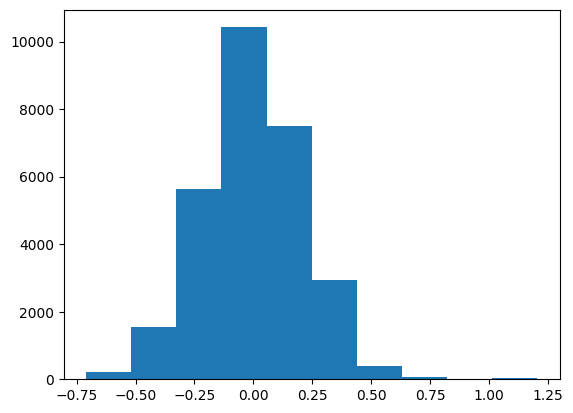

In [202]:
plt.hist(CAR['L_H_W_ratio'] - np.mean(CAR['L_H_W_ratio']))
plt.show()

In [199]:
tt = CAR['L_H_ratio'] - np.mean(CAR['L_H_ratio'])
tt[tt<-1.3]

array([], dtype=float64)

## ELAN Evaluation metrics (Dim delta, depth, alpha, Dim consistency)

In [266]:
split_dir = 'Elan_3d_box/ImageSets/val.txt'
vai_ids = [x.strip() for x in open(split_dir).readlines()]

file = f'Elan_3d_box/renew/{id_}.txt'


'000012'

In [270]:
# dim delta
import glob
split_dir = 'Elan_3d_box/ImageSets/val.txt'
val_ids = [x.strip() for x in open(split_dir).readlines()]

Elan_labels = glob.glob('Elan_3d_box/renew_label/*.txt')
Pred_elan_labels = glob.glob('0706_ELAN/*.txt')
Pred_kitti_labels = glob.glob('0706_ELAN2/*.txt')

dim_GT = list()
dim_ELAN = list()
dim_KITTI = list()

depth_GT = list()
depth_ELAN = list()
depth_KITTI = list()

alpha_GT = list()
alpha_ELAN = list()
alpha_KITTI = list()

for id_ in val_ids:
    elan_lines = [x.strip() for x in open(f'Elan_3d_box/renew_label/{id_}.txt').readlines()]
    objects = [DetectedObject(line) for line in elan_lines if line.split()[0]=='Car']
    for obj in objects:
        dim_GT.append(obj.dims[0])
        depth_GT.append(obj.locs[0][2])
        alpha_GT.append(obj.alphas[0])
        
    pred_elan_lines = [x.strip() for x in open(f'0706_ELAN/{id_}.txt').readlines()]
    objects = [DetectedObject(line) for line in pred_elan_lines]
    for obj in objects:
        dim_ELAN.append(obj.dims[0])
        depth_ELAN.append(obj.locs[0][2])
        alpha_ELAN.append(obj.alphas[0])
        
    pred_kitti_lines = [x.strip() for x in open(f'0706_ELAN2/{id_}.txt').readlines()]
    objects = [DetectedObject(line) for line in pred_kitti_lines]
    for obj in objects:
        dim_KITTI.append(obj.dims[0])
        depth_KITTI.append(obj.locs[0][2])
        alpha_KITTI.append(obj.alphas[0])
        
dim_GT = np.array(dim_GT)
dim_ELAN = np.array(dim_ELAN)
dim_KITTI = np.array(dim_KITTI)

depth_GT = np.array(depth_GT)
depth_ELAN = np.array(depth_ELAN)
depth_KITTI = np.array(depth_KITTI)

alpha_GT = np.array(alpha_GT)
alpha_ELAN = np.array(alpha_ELAN)
alpha_KITTI = np.array(alpha_KITTI)

print('ELAN')
delta_ELAN = np.mean(abs(dim_GT-dim_ELAN), axis=0)
print('[dim] delta', delta_ELAN)
dep_ELAN = depth_GT-depth_ELAN
print(f'[depth] delta abs_mean: {abs(dep_ELAN).mean():.4f}')
alph_ELAN = alpha_GT - alpha_ELAN
print(f'[alpha] delta abs_mean: {abs(alph_ELAN).mean():.4f}')

print('KITTI')
delta_KITTI = np.mean(abs(dim_GT-dim_KITTI), axis=0)
print('[dim] delta', delta_KITTI)
dep_KITTI = depth_GT-depth_KITTI
print(f'[depth] delta abs_mean: {abs(dep_KITTI).mean():.3f}')
alph_KITTI = alpha_GT - alpha_KITTI
print(f'[alpha] delta abs_mean: {abs(alph_KITTI).mean():.3f}')

ELAN
[dim] delta [0.116783   0.09239757 0.34751138]
[depth] delta abs_mean: 2.6329
[alpha] delta abs_mean: 0.0406
KITTI
[dim] delta [0.11737481 0.09188164 0.346783  ]
[depth] delta abs_mean: 2.621
[alpha] delta abs_mean: 0.040


In [259]:
import matplotlib.pyplot as plt
from ron_functions import *

box_depth_error_calculation(depth_GT, depth_ELAN, 5)
#plt.scatter(depth_GT, dep_ELAN, s=1)
#plt.show()

num of object: 3487
	num of depth 0-10: 0 	abs_delta mean:nanm, Out of 5m: 0
	num of depth 10-20: 608 	abs_delta mean:7.041m, Out of 5m: 523
	num of depth 20-30: 800 	abs_delta mean:11.919m, Out of 5m: 763
	num of depth 30-40: 1114 	abs_delta mean:18.218m, Out of 5m: 1082
	num of depth 40-50: 477 	abs_delta mean:22.889m, Out of 5m: 456
	num of depth 50-60: 269 	abs_delta mean:26.888m, Out of 5m: 257
	num of depth 60+: 219   	abs_delta mean:28.482m, Out of 5m: 206
[Total] mean:16.776, std:10.156
